# Transformers

Transformers are the state-of-the-art in Machine Learning, powering popular applications like Chat-GPT and GPT-4 (Generative Pretrained Transformer). Transformers are well suited for tasks that involve sequential data (text, images, sound) where the position of the elements conveys meaning: for example, the sentences "John eats a duck" and "a duck eats John" have very different meanings, despite containing the same words.

Transformers have at least one of the two following components: an encoder and a decoder. An encoder receives an input and builds an internal representation, while a decoder uses that internal representation (plus other inputs) to generate an input. Encoders are important in models that have to "understand" the input, for example in sentence classification, while decoders are good at generating texts. Tasks like translation or summarization require both encoding and decoding.

The transformer is not able to handle the inputs and outputs in their raw form, so it is always necessary to pre-process and post-process. An important part of processing is tokenization, where the sequences are split in smaller chuncks or tokens. In a text, a token might be a word, but also a part of a word (think lexemes and morphemes). You can see in real time GPT-4's tokenizer [here](https://platform.openai.com/tokenizer). Tokens are stored internally as integers, since Neural networks can only process numbers. The encoding takes care not only of the tokens, but also of their position.

The novelty of transformers is that they use attention layers, introduced in [arXiv:1706.03762](https://arxiv.org/abs/1706.03762). An attention layer temporarily increases the weight of some tokens and decreases the weight of others. For example, imagine that you want to translate the sentence "I buy a car" to Spanish: if you try to translate word-by-word (i.e. only attention to individual tokens), you can end up with disastrous results "Yo comprar un coche". To correctly translate the word "buy", you have to pay attention to the word "I" on front of it, to come up with "Yo compro" or even better just "compro"; on the other hand the tokens "a car" are completely irrelevant in translating the word "buy".

### Reading equations

As a practical application, we are going to use a transformer to parse images containing mathematical formulae into $\LaTeX$ expressions. We are going to use Nougat [arXiv:2308.13418](https://arxiv.org/pdf/2308.13418.pdf), an AI created by Meta/Facebook to process scientific PDFs.

Luckily, we don't neeed to train the model ourselves. We will use 🤗 (read as "Hugging Face"), wich is an open repository of pre-trained AI models: https://huggingface.co/. We will use the 🤗 models with the `python` package `transformers` (make sure to use at least version 4.34).

```bash
pip install transformers
```

We also need a LaTeX post-processor, that we get from GitHub and add to the `python` search path:

In [1]:
! git submodule add https://github.com/NormXU/nougat-latex-ocr

Cloning into '/workspaces/TFM_AlejandroMir/Lecciones/nougat-latex-ocr'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 113 (delta 32), reused 84 (delta 15), pack-reused 0
Receiving objects: 100% (113/113), 117.94 KiB | 3.37 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [2]:
import sys

sys.path.append('nougat-latex-ocr')

In [3]:
import torch
from transformers import VisionEncoderDecoderModel
from transformers.models.nougat import NougatTokenizerFast
from nougat_latex import NougatLaTexProcessor

/root/.cache/pypoetry/virtualenvs/tfm-alejandromir-_L8EXmOG-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The first time you use a model from `transformers`, it is downloaded from 🤗. The model is 1.4 GB, so it may take some time to download.

In [4]:
model_name = "Norm/nougat-latex-base"
device = "cuda" if torch.cuda.is_available() else "cpu"
# init model
model = VisionEncoderDecoderModel.from_pretrained(model_name).to(device)

# init processor
tokenizer = NougatTokenizerFast.from_pretrained(model_name)

latex_processor = NougatLaTexProcessor.from_pretrained(model_name)

In order to open the image we use the library `PIL` (aka `pillow`). The dataset contains three images, `dirac.png`, `dirac2.png` and `dirac3.png`, in decreasing quality. Let's try with the most challenging one:

In [5]:
from PIL import Image
image = Image.open("dirac3.png")
if not image.mode == "RGB":
    image = image.convert('RGB')

The command `display()` is exclusive to `Jupyter`. In pure `python` you would need to call `image.show()`.

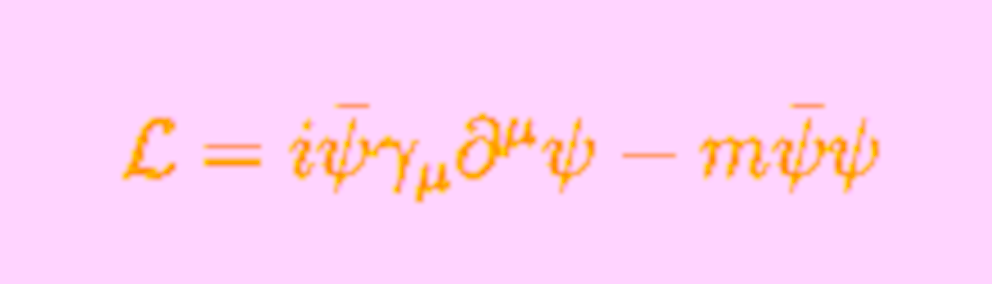

In [6]:
display(image)

The first step is to pre-process the image. The pre-processor resizes/crops the image as needed, as well as some other minor modifications:

In [7]:
pixel_values = latex_processor(image, return_tensors="pt").pixel_values

We can see each pre-processed channel (red, green and blue):

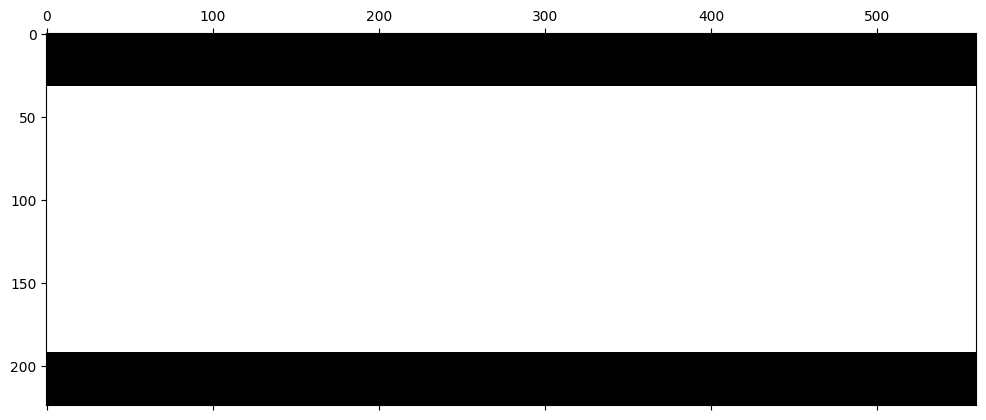

In [8]:
import matplotlib.pyplot as plt

plt.matshow(pixel_values[0][0], cmap="binary_r")

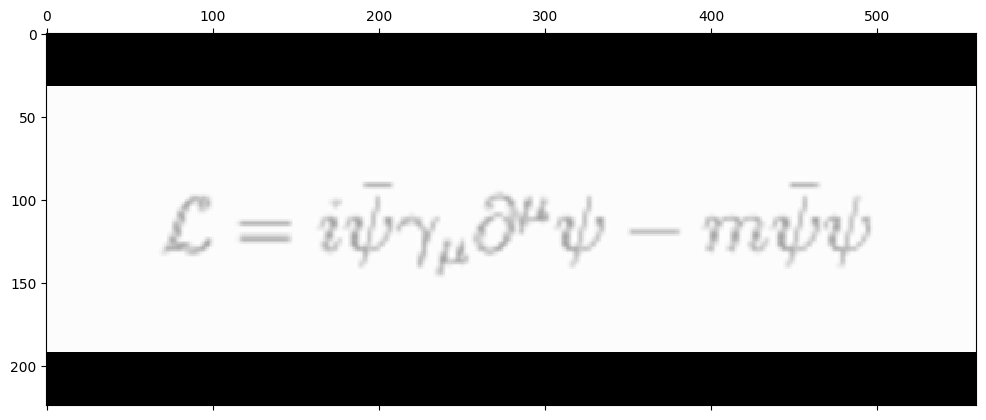

In [9]:
plt.matshow(pixel_values[0][1], cmap="binary_r")

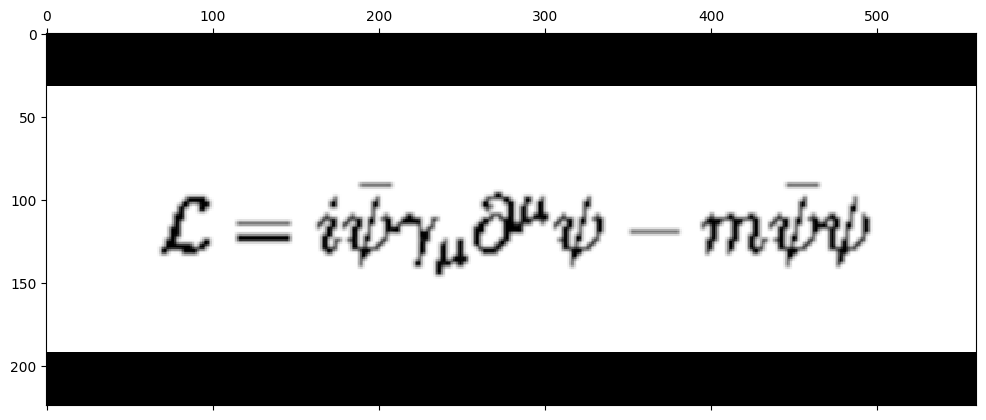

In [10]:
plt.matshow(pixel_values[0][2], cmap="binary_r")

In this step we use the AI model to convert the image into an output that hopefully will contain the $\LaTeX$ information. We have to provide some configurations, including special tokens: begining-of-sentence (`bos_token`), end-of-sentence (`eos_token`), padding (`pad_token`) and unknown token (`unk_token`).

In [11]:
decoder_input_ids = tokenizer(tokenizer.bos_token, add_special_tokens=False,
                              return_tensors="pt").input_ids

with torch.no_grad():
    outputs = model.generate(
        pixel_values.to(device),
        decoder_input_ids=decoder_input_ids.to(device),
        max_length=model.decoder.config.max_length,
        early_stopping=True,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
        use_cache=True,
        num_beams=5,
        bad_words_ids=[[tokenizer.unk_token_id]],
        return_dict_in_generate=True,
    )

/root/.cache/pypoetry/virtualenvs/tfm-alejandromir-_L8EXmOG-py3.10/lib/python3.10/site-packages/transformers/generation/utils.py:1421: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


Let's see what's inside the `output`:

In [12]:
outputs.sequences

tensor([[   0,   82,  923,  113,   66,  115,   51,   95,   82, 1658,  113,   82,
         2331,  115,   82, 1525,   85,  113,   82, 1221,  115,   82, 1736,   84,
          113,   82, 1221,  115,   82, 2331,   35,   99,   82, 1658,  113,   82,
         2331,  115,   82, 2331,    2]])

These are the numbers representing each token in the $\LaTeX$ expression. In order to get something readable, we have to decode it with the tokenizer:

In [13]:
tokenizer.decode(82)

'\\'

The token 82 corresponds to the backslash (remember that backslashes in `python` are escaped)

In [14]:
tokenizer.decode(923)

'mathcal'

And the token 923 corresponds to the command `mathcal`.

Let's decode the complete sequence:

In [15]:
sequence = tokenizer.batch_decode(outputs.sequences)[0]
print(sequence)

<s>\mathcal{L}=i\bar{\psi}\gamma_{\mu}\partial^{\mu}\psi-m\bar{\psi}\psi</s>


Now we only have to do some cleaning and remove the bos, eos and padding tokens:

In [16]:
sequence = sequence.replace(tokenizer.eos_token, "").replace(tokenizer.pad_token, "").replace(tokenizer.bos_token, "")
print(sequence)

\mathcal{L}=i\bar{\psi}\gamma_{\mu}\partial^{\mu}\psi-m\bar{\psi}\psi


And we find the correct $\LaTeX$ sequence!

$\mathcal{L}=i\bar{\psi}\gamma_{\mu}\partial^{\mu}\psi-m\bar{\psi}\psi$